In [3]:
#importing required libraries
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix
import scipy.cluster.hierarchy as sch
import sys
from sklearn import preprocessing

sys.setrecursionlimit(100000)

In [4]:
#Change parameters as needed
l2input_data_filepath = "data_with_imputated_derived_features_l2input_v6_08_02_22.csv"
l1output_filepath = "Final_L1_seg_output_08_02_22.csv"
predict=True#If this is true we will be using the saved pickle file as the model while if it false we will be running the model again.
segmentation_features = ['HCP_ID', 'email_open_rate', 'email_click_rate',
       'Ad_click_rate', 'F2F_accessibility', "F2F_CALL_decile","PHONE_CALL_decile", 
                         "DIGITAL_CALL_decile",  "rep_triggered_email_decile"]
features_to_scale = ['email_open_rate', 'email_click_rate',
       'Ad_click_rate', 'F2F_accessibility']

lev2output_filepath = "lev2_segmentation_output_v20_08_02_22.csv"


l2_meandf_filepath = "lev2_segmentation_mean_features_v20.csv"
l2_weighteddf_filepath = "lev2_segment_weighted_feature_scores_v20.csv" 
merged_lev2_output_filepath = "lev2_merged_segmentation_output_v20_09_02_22.csv"


In [5]:

def get_l1_output(lev1_segment):
    '''
    This function is used to select hcp_id and sement columns from L1 output file
    lev1_segment:L1 output file
    '''
    lev1_segment = lev1_segment[["HCP_ID","Segment_1"]] #.rename(columns = {"Cluster":"Segment_1"})
    return lev1_segment

def scaling(data_, features_to_scale):
    '''
    This function is used to standardise the features.
    data_:input data 
    features_to_scale:features needed to be scaled
    '''
    data_[features_to_scale] = StandardScaler().fit_transform(data_[features_to_scale])
    return data_

def get_l2input_data(input_df, l1_output, segmentation_features, features_to_scale):
    '''
    This function is used create final L2 input data.
    input_df:data for Level 2 segmentation after imputation
    l1_output:output from L1 segmentation
    segmentation_features:features list to be considered for segmentation
    features_to_scale:features list to be scaled
    '''
    data = input_df[segmentation_features]
    data = scaling(data, features_to_scale)
    l1_output = get_l1_output(l1_output)
    data = data[data["HCP_ID"].isin(l1_output["HCP_ID"].unique())]
    data = data.merge(l1_output, on="HCP_ID", how="right")
    data = data.fillna(value = 0.0)
    data.replace([np.inf, -np.inf], 0.0, inplace=True)
    print(data["HCP_ID"].nunique())
    return data


In [6]:
def agglomerative_clustering(to_seg_df, displa):
    '''
    This function is used to perform hierarchical agglomerative clustering.
    to_seg_df:input data
    displa:boolean value to display dendrogram
    '''
    # Plot/Extract dendrogram output
    X = to_seg_df.drop(columns = ["HCP_ID","Segment_1"])
    dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
    # Extract optimal number of clusters from dendrogram
    numclusters = len(list(set(dendrogram['color_list']))) - 1
    # Display dendrogram
    if displa == True:
        plt.title('Dendrogram')
        plt.xlabel('Customers')
        plt.ylabel('Euclidean distances')
        display()

    # Run Hierarchical clustering using the optimal number of clusters from the dendrogram
    hcluster = AgglomerativeClustering(n_clusters=numclusters, affinity='euclidean', linkage='ward')
    hcluster.fit(X)
    to_seg_df["Segment_2"] = hcluster.labels_
    to_seg_df["Segment_2"] = "seg2_" + to_seg_df["Segment_2"].astype(str)
    return to_seg_df

def elbow_curve(data_):
    '''
    This function is used to obtain the optimal clusters using elbow curve.
    data_:input data
    '''
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 15)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(data_)
        kmeanModel.fit(data_)

        distortions.append(sum(np.min(cdist(data_, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / data_.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(data_, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / data_.shape[0]
        mapping2[k] = kmeanModel.inertia_

    #RANGE 1 to 15
    for key, val in mapping1.items():
        print(f'{key} : {val}')

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    print(plt.show())


def kmeans_model(to_seg_df, predict, seg1):
    '''
    This function is used to run kmeans algorithm.
    '''
    X = to_seg_df.drop(columns = ["HCP_ID","Segment_1"])
    elbow_curve(X)
    if predict == True:
        kmeans = pickle.load(open("kmeans_model"+seg1+".pkl", "rb"))
    else:
        print(f"Enter number of clusters :")
        n = int(input())
        kmeans = KMeans(n_clusters=n)
        pickle.dump(kmeans, open("kmeans_model"+seg1+".pkl", "wb"))
    kmeanModel = kmeans.fit(X)
    to_seg_df["Segment_2"] = kmeanModel.labels_
    to_seg_df["Segment_2"] = "seg2_" + to_seg_df["Segment_2"].astype(str)
    return to_seg_df

def l2_segmentation(df):
    '''
    This function is used to loop through all L1 segments to get L2 micro-segments
    df: Data for L2 segmentation
    '''
    df_seg = df.copy()
    df["Segment_2"] = ""
    for seg1 in df["Segment_1"].unique():
        print("SEGMENT 1 : ", seg1)
        data_to_segment = df_seg[df_seg["Segment_1"] == seg1]
        #Agglomerative clustering
#         to_seg_df = agglomerative_clustering(data_to_segment, "False")
        to_seg_df = kmeans_model(data_to_segment, predict, seg1)
        
        df.loc[df["HCP_ID"].isin(to_seg_df["HCP_ID"]), "Segment_2"] = to_seg_df["Segment_2"]
    return df

/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


183152
SEGMENT 1 :  Segment1_5
1 : 1.39879130777729
2 : 0.9667114610624361
3 : 0.7627573856406763
4 : 0.7061056797138561
5 : 0.6544964277654012
6 : 0.6490725002436811
7 : 0.5239055282004156
8 : 0.5079988204796849
9 : 0.47527788300569906
10 : 0.4577679110148171
11 : 0.43075317520814765
12 : 0.41606842000599753
13 : 0.40651102013464946
14 : 0.3840431247575807


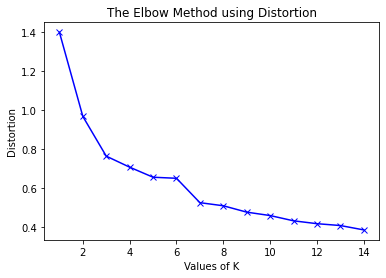

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_7
1 : 1.15955545670404
2 : 0.993247279004101
3 : 0.754756254848439
4 : 0.640057032051337
5 : 0.6263552496506046
6 : 0.5859530978149664
7 : 0.5755449236391429
8 : 0.4841796879477961
9 : 0.5160325118750562
10 : 0.44366292070988256
11 : 0.4207440289076722
12 : 0.3620993190159784
13 : 0.34742369958529334
14 : 0.34840580877605054


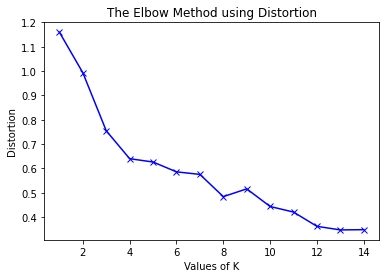

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_0
1 : 1.1302872576290943
2 : 0.8891362849164361
3 : 0.8815585152363364
4 : 0.725481683491821
5 : 0.6239480055566764
6 : 0.5675703884507074
7 : 0.5412044199686364
8 : 0.5088440747671331
9 : 0.49403415467345585
10 : 0.48705794329050967
11 : 0.4207511291886164
12 : 0.3819158952312932
13 : 0.36902674576606154
14 : 0.36307748091587366


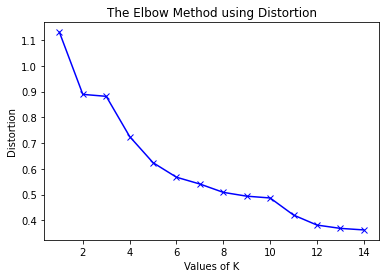

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_1
1 : 1.1766213065058024
2 : 1.1632845311189581
3 : 0.9403808192549675
4 : 0.7808528037471438
5 : 0.762719840467446
6 : 0.6601318669764553
7 : 0.6074863775720587
8 : 0.6310377810934775
9 : 0.5768256804241749
10 : 0.5444394981352135
11 : 0.45043607279267284
12 : 0.4195651953453181
13 : 0.4150343567848879
14 : 0.39299363779466123


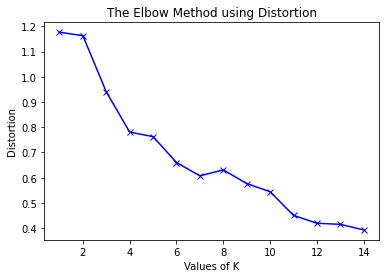

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_4
1 : 1.1374815801471503
2 : 0.9245895063965912
3 : 0.7187638095764961
4 : 0.631125489425165
5 : 0.578915057370439
6 : 0.5613181210561196
7 : 0.5565367547559831
8 : 0.5499799327211299
9 : 0.45609662177720484
10 : 0.42860900315885936
11 : 0.38872264227658215
12 : 0.4003072764385557
13 : 0.3665658128562594
14 : 0.3686851235170553


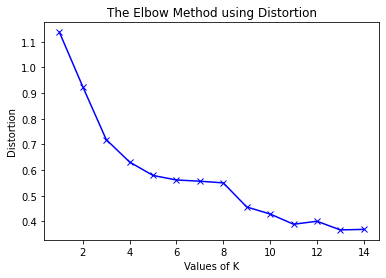

None
Enter number of clusters :
13


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_2
1 : 1.691512359847097
2 : 0.9823645270110828
3 : 0.812200752463393
4 : 0.7526113282984087
5 : 0.7482791212029236
6 : 0.6231216696620507
7 : 0.5809506634535992
8 : 0.5632655739829765
9 : 0.5072487119163693
10 : 0.49904538153878897
11 : 0.4773839465246735
12 : 0.43893100616735126
13 : 0.43223265446156955
14 : 0.41774560128845406


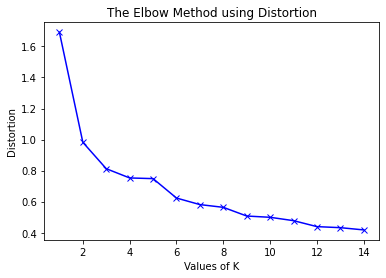

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_6
1 : 1.0083250789295524
2 : 0.7634095071518633
3 : 0.7316139069663729
4 : 0.6488461502517636
5 : 0.6408091004986806
6 : 0.6005311847120486
7 : 0.5429624398509377
8 : 0.5257501920698101
9 : 0.442814818490558
10 : 0.4141022168456646
11 : 0.4040298211807227
12 : 0.34742970898903125
13 : 0.3349532607007493
14 : 0.32715037018421195


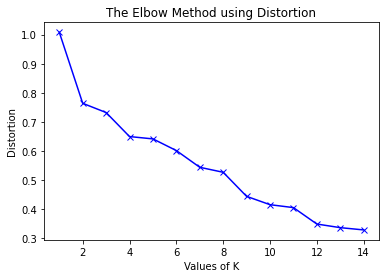

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_3
1 : 1.272464074618794
2 : 1.2483618964512644
3 : 1.0521334744499646
4 : 0.8014218737433761
5 : 0.7769110313289708
6 : 0.7581351995511284
7 : 0.7051256860029426
8 : 0.6532474950292976
9 : 0.5295327070370485
10 : 0.5199122964839022
11 : 0.5047141261754228
12 : 0.48381941612537954
13 : 0.4425594461827413
14 : 0.4439040037883906


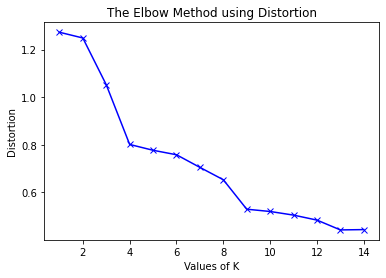

None
Enter number of clusters :
13


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_8
1 : 1.0298099556602183
2 : 0.7898529723407572
3 : 0.6714970048564948
4 : 0.5678283384566342
5 : 0.5361553940520086
6 : 0.5289386192208936
7 : 0.5018837230791962
8 : 0.4502660877325506
9 : 0.431122741935439
10 : 0.38337447468142527
11 : 0.3709558813718726
12 : 0.3657869430898303
13 : 0.3334689921034366
14 : 0.3204293184849772


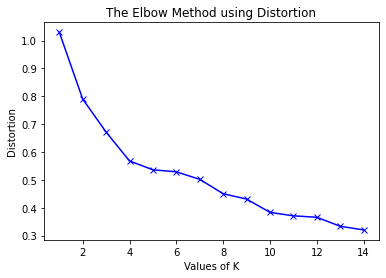

None
Enter number of clusters :
14


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Final Number of Micro-Segments are 124


In [7]:
def run_level2_segmentation():
    #RUN LEVEL 2 SEGMENTATION
    input_df = pd.read_csv(l2input_data_filepath)
    l1_output = pd.read_csv(l1output_filepath)

    input_data = get_l2input_data(input_df, l1_output, segmentation_features, features_to_scale)
    final_output = l2_segmentation(input_data)
    final_output["Segment"] = final_output["Segment_1"] + final_output["Segment_2"]
    print("Final Number of Micro-Segments are", final_output["Segment"].nunique())
    final_output = input_df.merge(final_output[["HCP_ID","Segment","Segment_1","Segment_2"]], on="HCP_ID", how="left")
    
    return final_output

final_output = run_level2_segmentation()
final_output.to_csv(lev2output_filepath, index=False)

/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


183152
SEGMENT 1 :  Segment1_5
1 : 1.39879130777729
2 : 0.9667114610624361
3 : 0.7627573856406762
4 : 0.7061056797138561
5 : 0.6544964277654012
6 : 0.6497058620595035
7 : 0.5635905117213741
8 : 0.5204423321484576
9 : 0.46065535117909323
10 : 0.46743742115239806
11 : 0.4535522378821659
12 : 0.4129145223249395
13 : 0.41213836141030075
14 : 0.37524575859797804


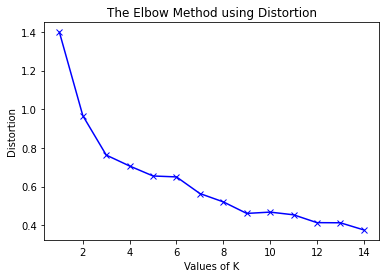

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_7
1 : 1.15955545670404
2 : 0.993247279004101
3 : 0.7547562548484398
4 : 0.6404779783838307
5 : 0.6269137118331474
6 : 0.6081431336340166
7 : 0.5761680342991164
8 : 0.5609300021148093
9 : 0.4797045943663074
10 : 0.4444813709431265
11 : 0.4255080327880733
12 : 0.39599852938096614
13 : 0.3469660593277249
14 : 0.34272013603500817


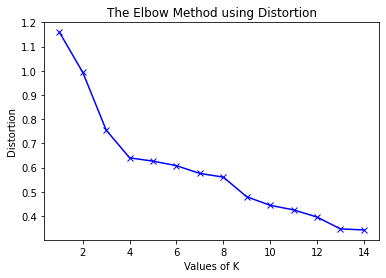

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_0
1 : 1.1302872576290943
2 : 0.8922600028509063
3 : 0.881770248337604
4 : 0.725481683491821
5 : 0.6239480055566764
6 : 0.5666489443658229
7 : 0.5411761046220399
8 : 0.5366126034204155
9 : 0.5022775310647465
10 : 0.431289762451727
11 : 0.42138399007509814
12 : 0.3831842344265595
13 : 0.3661941894855622
14 : 0.35477634599446606


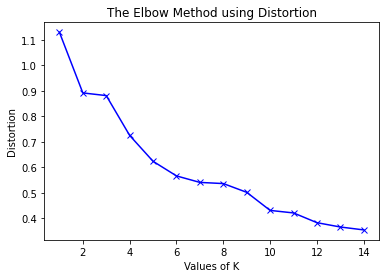

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_1
1 : 1.1766213065058024
2 : 1.1632845311189581
3 : 0.9389667796284535
4 : 0.7815628889527919
5 : 0.6809353813786636
6 : 0.660452767407147
7 : 0.6526195545053152
8 : 0.5945497200604324
9 : 0.5777459216081076
10 : 0.4885083983393657
11 : 0.4530645544855924
12 : 0.4201188160085119
13 : 0.41389593499996874
14 : 0.3962288213051956


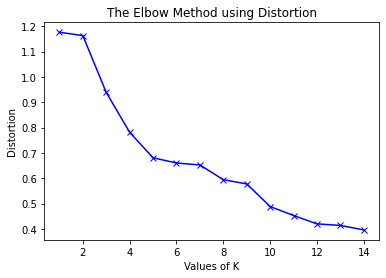

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_4
1 : 1.1374815801471503
2 : 0.9245895063965912
3 : 0.7187357982177757
4 : 0.6306887414838468
5 : 0.5787093487679932
6 : 0.5601550248849756
7 : 0.5542212784095837
8 : 0.5440379696271135
9 : 0.4503725162645797
10 : 0.42787721151704683
11 : 0.3901849414768312
12 : 0.38556512195936776
13 : 0.34701489300276406
14 : 0.3415730792175978


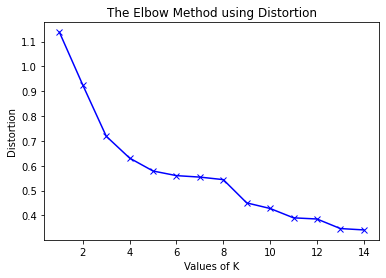

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_2
1 : 1.691512359847097
2 : 0.9823645270110828
3 : 0.8116711399230743
4 : 0.752827709497799
5 : 0.7479431956300996
6 : 0.6234602722970164
7 : 0.691293175446935
8 : 0.5627626924956071
9 : 0.5538252353927653
10 : 0.495418460440953
11 : 0.4752001236596038
12 : 0.43965188021396634
13 : 0.4210271294930263
14 : 0.4166748105710576


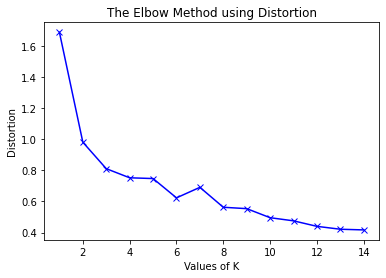

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_6
1 : 1.0083250789295524
2 : 0.7634095071518632
3 : 0.7391829165840264
4 : 0.6488461502517636
5 : 0.6405388317993945
6 : 0.5988477772281428
7 : 0.512115014452984
8 : 0.5322757994504882
9 : 0.4407312129009989
10 : 0.4124094546350098
11 : 0.40402982118072267
12 : 0.3593124665336367
13 : 0.3391754151973266
14 : 0.3368299157406616


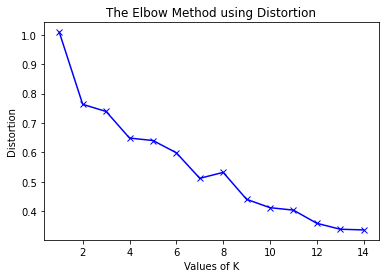

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_3
1 : 1.272464074618794
2 : 1.2483618964512644
3 : 1.0465041694591535
4 : 0.8020563821702136
5 : 0.7799484896476107
6 : 0.7599477998566326
7 : 0.7073245396378396
8 : 0.651346524385161
9 : 0.5292619184912943
10 : 0.5184792196878633
11 : 0.4875788231396227
12 : 0.4592084547741811
13 : 0.4527515062255428
14 : 0.43254979858543896


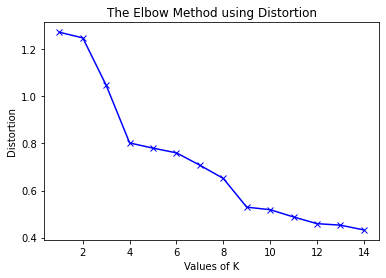

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SEGMENT 1 :  Segment1_8
1 : 1.0298099556602183
2 : 0.7899340516134624
3 : 0.6714970048564948
4 : 0.5678283384566342
5 : 0.5361553940520086
6 : 0.5248237781483917
7 : 0.501779831671299
8 : 0.4502660877325506
9 : 0.4265494079960268
10 : 0.3709722223657658
11 : 0.3637969597503311
12 : 0.33643551881749245
13 : 0.3181203901016416
14 : 0.31219347637530787


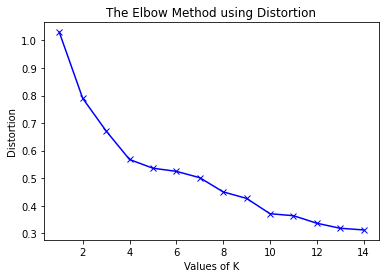

None


/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/python36/consumer/crmdb-zs/crmdb-zspy36/lib64/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Final Number of Micro-Segments are 124


In [7]:
input_df = pd.read_csv(l2input_data_filepath)
l1_output = pd.read_csv(l1output_filepath)

input_data = get_l2input_data(input_df, l1_output, segmentation_features, features_to_scale)
final_output = l2_segmentation(input_data)
final_output["Segment"] = final_output["Segment_1"] + final_output["Segment_2"]
print("Final Number of Micro-Segments are", final_output["Segment"].nunique())
final_output = input_df.merge(final_output[["HCP_ID","Segment","Segment_1","Segment_2"]], on="HCP_ID", how="left")

## POST PROCESSING OF MICRO-SEGMENTS (PROFILING IN PYTHON)

In [9]:
def post_processing_l2_segments(final_output):
    '''
    Function to perform post processing and calculate mean and weighted feature scores for every segment
    '''
    final_output =  final_output.dropna()
    #mean df creation
    mean_df = final_output.groupby(["Segment"]).mean().reset_index()
    mean_df["#HCPS"] = final_output.groupby(["Segment"]).agg({"HCP_ID":"count"}).reset_index()["HCP_ID"]
    mean_data = mean_df.copy()
    mean_df = mean_df.pivot_table(columns="Segment")
    #Getting weighted feature scores 
    df = mean_df.copy()
    weighted_score = [1]
    df["weighted_scores"] = 0
    for i in range(1,df.shape[0]):
        wt_score = sum(df.iloc[0,:]*df.iloc[i,:])/sum(df.iloc[0,:])
        weighted_score.append(wt_score)

    df["weighted_scores"] = weighted_score
    weighted_df = df.copy()
    col_list = weighted_df.columns.to_list()
    col_list = col_list[:len(col_list)]
    for col in col_list:
        weighted_df[col] = weighted_df[col]*100/weighted_df["weighted_scores"]

    weighted_df = weighted_df.T
    weighted_df["#HCPS"] = weighted_df["#HCPS"]/100
    weighted_df = weighted_df.sort_values(by = ["#HCPS"], ascending = False)
    weighted_df = weighted_df.T
    weighted_df = weighted_df.reset_index().rename(columns = {"index":"Features"})

    return mean_df, weighted_df

In [10]:
mean_df, weighted_df = post_processing_l2_segments(final_output)
mean_df.to_csv(l2_meandf_filepath, index=False)
weighted_df.to_csv(l2_weighteddf_filepath, index=False)

## MERGING MICRO-SEGMENTS 

In [11]:
merge_segment_map = 
{
"Segment1_0seg2_1":["Segment1_0seg2_1","Segment1_0seg2_2"],
"Segment1_1seg2_1":["Segment1_1seg2_1","Segment1_1seg2_4"],
"Segment1_1seg2_2":["Segment1_1seg2_2","Segment1_1seg2_3"],
"Segment1_3seg2_0":["Segment1_3seg2_0","Segment1_3seg2_1"],
"Segment1_4seg2_2":["Segment1_4seg2_2","Segment1_4seg2_3"],
"Segment1_6seg2_1":["Segment1_6seg2_1","Segment1_6seg2_2"],
"Segment1_6seg2_0":["Segment1_6seg2_0","Segment1_6seg2_3"],
"Segment1_8seg2_1":["Segment1_8seg2_1","Segment1_8seg2_2"]
}


In [20]:
def merge_lev2_segments(final_output, merge_segment_map):
    '''
    Function to merge segments and get segment wise #HCPs distribution
    '''
    for seg in merge_segment_map.keys():
        final_output.loc[final_output["Segment"].isin(merge_segment_map[seg]), "Segment"]=seg

    print("Final num of segments", final_output["Segment"].nunique())

    le = preprocessing.LabelEncoder()
    final_output["Segment_v0"] = final_output["Segment"]
    final_output["Segment"] =le.fit_transform(final_output["Segment"])
    final_output["Segment"] = "Segment_" + final_output["Segment"].astype(str)

    segg = final_output.groupby("Segment").agg({"HCP_ID":"count"}).reset_index()
    segg["bins"] = pd.cut(segg["HCP_ID"], bins=[0,500,1000,2000,5000,10000,20000,250000,500000])
    print(segg.groupby(["bins"]).count())
    
    return final_output

merged_final_output = merge_lev2_segments(final_output, merge_segment_map)
merged_final_output.to_csv(merged_lev2_output_filepath, index = False)

In [34]:
ml2_meandf_filepath = "lev2_merged_segmentation_mean_features_v20_090222.csv"
ml2_weighteddf_filepath = "lev2_merged_segment_weighted_feature_scores_v20_090222.csv"

mmean_df, mweighted_df = post_processing_l2_segments(merged_final_output)
mmean_df.to_csv(ml2_meandf_filepath, index=False)
mweighted_df.to_csv(ml2_weighteddf_filepath, index=False)

In [26]:
##To be run if product level features are included


# zyrtec_df_cols = ["HCP_ID"]+[i+" zyrtec" for i in zyrtec_df.columns if i!="HCP_ID"]
# zyrtec_df.columns = zyrtec_df_cols 
# tylenol_df_cols = ["HCP_ID"]+[i+" tylenol" for i in tylenol_df.columns if i!="HCP_ID"]
# tylenol_df.columns = tylenol_df_cols

# zy_seg_features = [i+" zyrtec" for i in segmentation_features if i!="HCP_ID"]
# ty_seg_features = [i+" tylenol" for i in segmentation_features if i!="HCP_ID"]
# zy_seg_features.remove("Ad_click_rate zyrtec")
# segmentation_features = segmentation_features+zy_seg_features+ty_seg_features

# zy_seg_features = [i+" zyrtec" for i in features_to_scale]
# ty_seg_features = [i+" tylenol" for i in features_to_scale]
# zy_seg_features.remove("Ad_click_rate zyrtec")
# features_to_scale = features_to_scale+zy_seg_features+ty_seg_features
# input_df = input_df.merge(tylenol_df, on="HCP_ID", how="left")
# input_df = input_df.merge(zyrtec_df, on="HCP_ID", how="left")